## Simulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import scipy.stats as stats
from sklearn.model_selection import train_test_split

### Version 1 : plusieurs fois la simulation

In [2]:
def power_simulation_multi(n, m, num_simulations=1000):

    np.random.seed(42)
    power = []
    esperances = []
    variances = []
    test_statistics = []
    test_alternative = []
    epsilon = np.random.normal(0, 1, n + m)
    x = np.random.uniform(0, 5, n + m)
    beta1 = 2
    beta2_values = np.linspace(0, 0.16, 9)

    for beta2 in beta2_values:

        differences = []

        for _ in range(num_simulations):
            y = beta1 * x + beta2 * x**2 + epsilon

            x_reshape = x.reshape(-1,1)

            x_train, x_test, y_train, y_test = train_test_split(x_reshape, y, test_size=m, random_state=42)

            # Linear Model
            model_a1 = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
            y_pred_a1 = model_a1.predict(x_test.reshape(-1, 1))
            mse_a1 = mean_squared_error(y_test, y_pred_a1)

            # Quadratic Model
            x_train_quad = np.column_stack((x_train, x_train**2))
            model_a2 = LinearRegression().fit(x_train_quad, y_train)
            x_test_quad = np.column_stack((x_test, x_test**2))
            y_pred_a2 = model_a2.predict(x_test_quad)
            mse_a2 = mean_squared_error(y_test, y_pred_a2)

            differences.append(mse_a1 - mse_a2)

        d_barre = sum(differences)/num_simulations 
        var = np.var(differences, ddof=1)
        test_stat = (num_simulations**0.5)*d_barre/np.sqrt(var) # Statistique pour l'hypothèse nulle

        delta = 0.1
        student = stats.t.ppf(0.95, df=num_simulations-1)
        mu = (num_simulations ** 0.5)*delta/np.sqrt(var)
        test_alt = student - mu
        puissance = 1 - stats.norm.cdf(student - mu, 0, 1)
       
        esperances.append(d_barre)
        variances.append(var)
        test_statistics.append(test_stat)
        test_alternative.append(test_alt)
        power.append(puissance)

    return esperances, variances, test_statistics, test_alternative, power


/var/folders/9q/r5nj4zj109n1sfs2g81wbkhc0000gq/T/ipykernel_31684/236877671.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  test_stat = (num_simulations**0.5)*d_barre/np.sqrt(var) # Statistique pour l'hypothèse nulle
/var/folders/9q/r5nj4zj109n1sfs2g81wbkhc0000gq/T/ipykernel_31684/236877671.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  mu = (num_simulations ** 0.5)*delta/np.sqrt(var)
/var/folders/9q/r5nj4zj109n1sfs2g81wbkhc0000gq/T/ipykernel_31684/236877671.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  test_stat = (num_simulations**0.5)*d_barre/np.sqrt(var) # Statistique pour l'hypothèse nulle
/var/folders/9q/r5nj4zj109n1sfs2g81wbkhc0000gq/T/ipykernel_31684/236877671.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  mu = (num_simulations ** 0.5)*delta/np.sqrt(var)
/var/folders/9q/r5nj4zj109n1sfs2g81wbkhc0000gq/T/ipykernel_31684/236877671.py:41: RuntimeWarning: divide by zero encountered in scalar divid

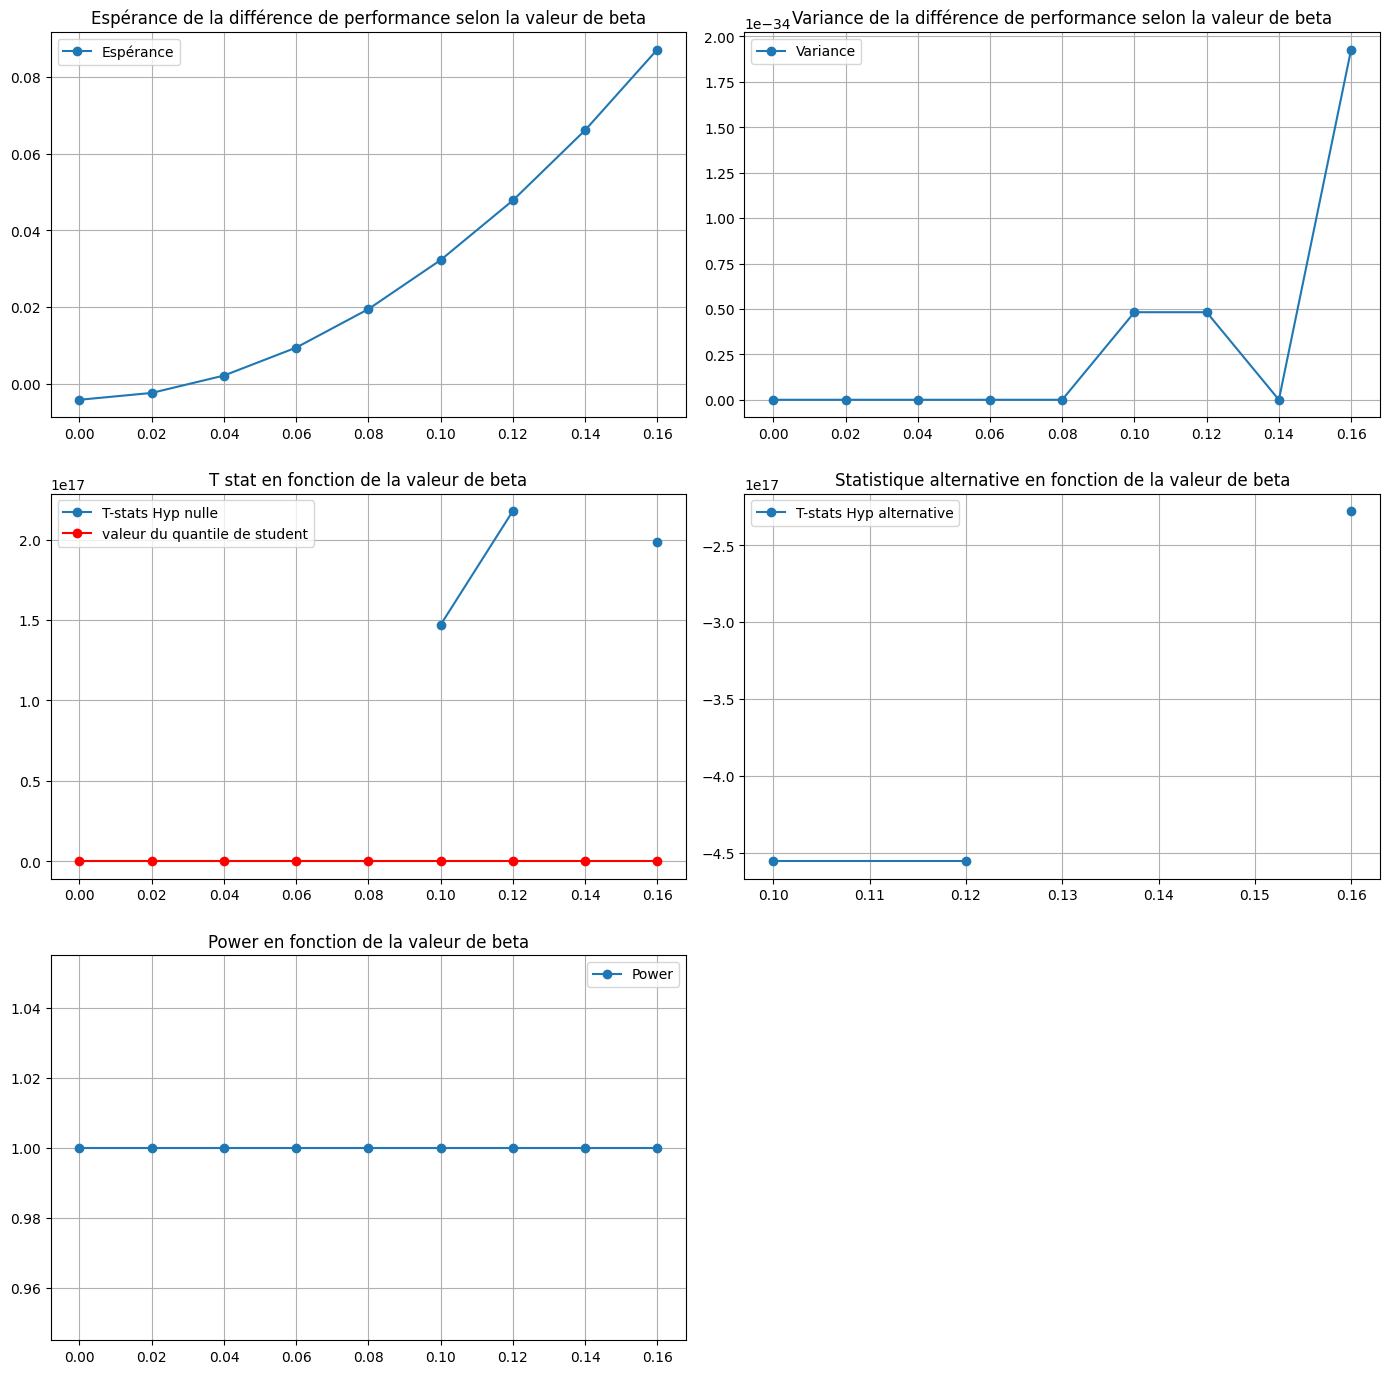

In [3]:
esperances, variances, test_statistics, test_alternative, power = power_simulation_multi(150, 2000, 1000)

beta2_values = np.linspace(0, 0.16, 9)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))

# Premier sous-graphe : Espérance
axes[0, 0].plot(beta2_values, esperances, label='Espérance', marker='o')
axes[0, 0].set_title('Espérance de la différence de performance selon la valeur de beta')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Deuxième sous-graphe : Variance
axes[0, 1].plot(beta2_values, variances, label='Variance', marker='o')
axes[0, 1].set_title('Variance de la différence de performance selon la valeur de beta')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Troisième sous-graphe : T-stat Hyp nulle
axes[1, 0].plot(beta2_values, test_statistics, label='T-stats Hyp nulle', marker='o')
axes[1, 0].plot(beta2_values, [stats.t.ppf(0.95, df=9)]*len(beta2_values), label='valeur du quantile de student', color='r', marker='o')
axes[1, 0].set_title('T stat en fonction de la valeur de beta')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quatrième sous-graphe : T-stat Hyp alternative
axes[1, 1].plot(beta2_values, test_alternative, label='T-stats Hyp alternative', marker='o')
axes[1, 1].set_title('Statistique alternative en fonction de la valeur de beta')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Cinquième sous-graphe : Power
axes[2, 0].plot(beta2_values, power, label='Power', marker='o')
axes[2, 0].set_title('Power en fonction de la valeur de beta')
axes[2, 0].legend()
axes[2, 0].grid(True)

# Cache le 6ème sous-graphe vide
fig.delaxes(axes[2, 1])

# Ajuste la disposition pour éviter les chevauchements
plt.tight_layout()
plt.show()

### Version 2 : bootstrappée

In [4]:
def power_simulation_boot(n,B,m):
        
   np.random.seed(42)
   esperances = []
   variances = []
   test_statistics = []
   test_alternative = []
   power = []
   epsilon = np.random.normal(0, 1, n+m)
   x = np.random.uniform(0, 5, n+m)
   beta1 = 2
   beta2_values = np.linspace(0, 0.16, 9)

   bootstrap_indices = np.random.choice(n, size=(B, n), replace=True) # bootstrapping

   for beta2 in beta2_values:
       
       y = beta1 * x + beta2 * x**2 + epsilon # generation de données
       x_train = x[:n]
       y_train = y[:n]

       x_test = x[n:n+m]
       y_test = y[n:n+m]

       db = []
       
       for bootstrap_index in bootstrap_indices:
       
          x_train = x[bootstrap_index]
          y_train = beta1 * x_train + beta2 * x_train**2 + epsilon[bootstrap_index]

          x_train_reshape = x_train.reshape(-1, 1) # fit pour le modèle 
          model_a1 = LinearRegression().fit(x_train_reshape, y_train) # Modèle linéaire
          y_pred_a1 = model_a1.predict(x_test.reshape(-1,1))
          p1b = mean_squared_error(y_test, y_pred_a1)

          x_train_quad = np.column_stack((x_train, x_train**2))
          model_a2 = LinearRegression().fit(x_train_quad, y_train)
          x_test_quad = np.column_stack((x_test, x_test**2))
          y_pred_a2 = model_a2.predict(x_test_quad)
          p2b = mean_squared_error(y_test, y_pred_a2)

          db.append(p1b - p2b)  # Différence des moyennes de performance sur chaque bootstrap

       # Fin du boostrapping

       d_barre = sum(db)/B # Converge p.s vers l'espérance mu

       var = np.var(db, ddof=1)
       test_stat = (B**0.5)*d_barre/np.sqrt(var) # Statistique pour l'hypothèse nulle

       delta = 0.1
       student = stats.t.ppf(0.95, df=B-1)
       mu = (B ** 0.5)*delta/np.sqrt(var)
       test_alt = student - mu
       puissance = 1 - stats.norm.cdf(student - mu, 0, 1)
       
       esperances.append(d_barre)
       variances.append(var)
       test_statistics.append(test_stat)
       test_alternative.append(test_alt)
       power.append(puissance)

   return esperances, variances, test_statistics, test_alternative, power


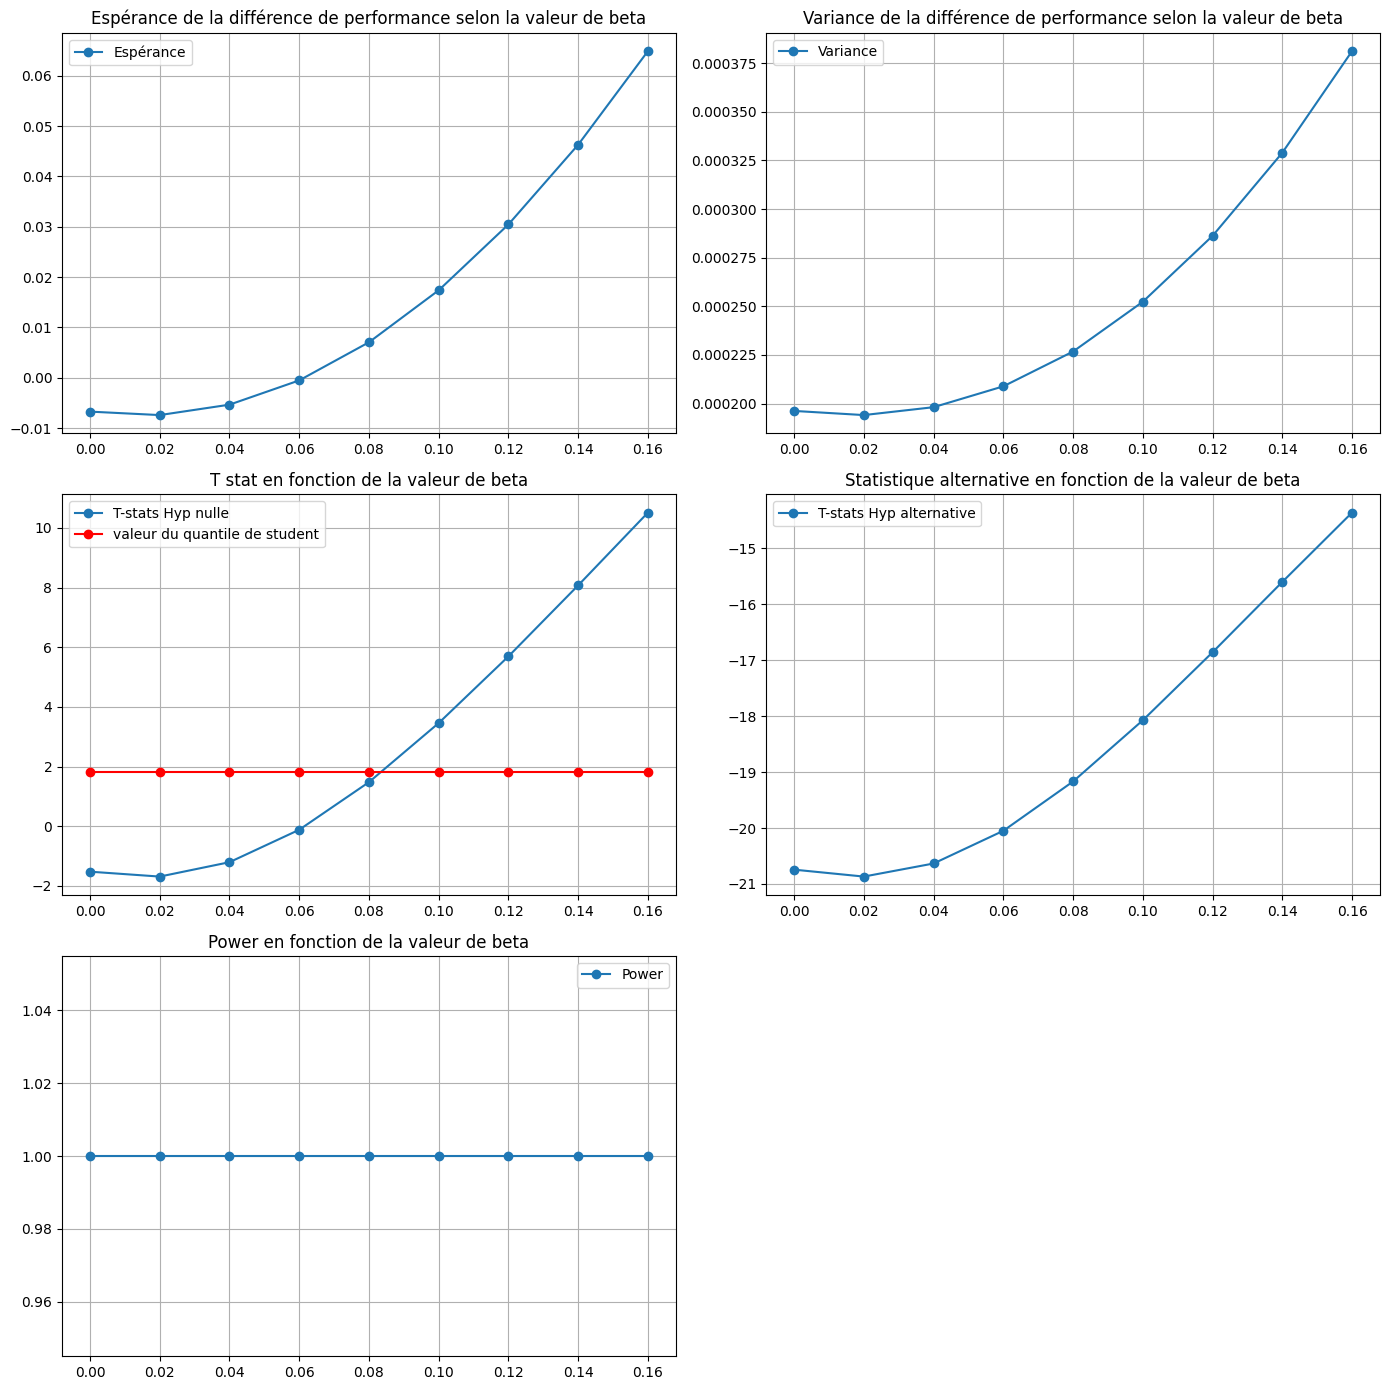

In [6]:
esperances, variances, test_statistics, test_alternative, power = power_simulation_boot(150, 10, 150)

beta2_values = np.linspace(0, 0.16, 9)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))

# Premier sous-graphe : Espérance
axes[0, 0].plot(beta2_values, esperances, label='Espérance', marker='o')
axes[0, 0].set_title('Espérance de la différence de performance selon la valeur de beta')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Deuxième sous-graphe : Variance
axes[0, 1].plot(beta2_values, variances, label='Variance', marker='o')
axes[0, 1].set_title('Variance de la différence de performance selon la valeur de beta')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Troisième sous-graphe : T-stat Hyp nulle
axes[1, 0].plot(beta2_values, test_statistics, label='T-stats Hyp nulle', marker='o')
axes[1, 0].plot(beta2_values, [stats.t.ppf(0.95, df=9)]*len(beta2_values), label='valeur du quantile de student', color='r', marker='o')
axes[1, 0].set_title('T stat en fonction de la valeur de beta')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quatrième sous-graphe : T-stat Hyp alternative
axes[1, 1].plot(beta2_values, test_alternative, label='T-stats Hyp alternative', marker='o')
axes[1, 1].set_title('Statistique alternative en fonction de la valeur de beta')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Cinquième sous-graphe : Power
axes[2, 0].plot(beta2_values, power, label='Power', marker='o')
axes[2, 0].set_title('Power en fonction de la valeur de beta')
axes[2, 0].legend()
axes[2, 0].grid(True)

# Cache le 6ème sous-graphe vide
fig.delaxes(axes[2, 1])

# Ajuste la disposition pour éviter les chevauchements
plt.tight_layout()
plt.show()